<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Steps:" data-toc-modified-id="Steps:-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Steps:</a></span></li><li><span><a href="#General" data-toc-modified-id="General-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>General</a></span></li></ul></li><li><span><a href="#DATA" data-toc-modified-id="DATA-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>DATA</a></span><ul class="toc-item"><li><span><a href="#Data-directories" data-toc-modified-id="Data-directories-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data directories</a></span></li></ul></li><li><span><a href="#The-CNN-model" data-toc-modified-id="The-CNN-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>The CNN model</a></span><ul class="toc-item"><li><span><a href="#Train-the-model" data-toc-modified-id="Train-the-model-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Train the model</a></span></li><li><span><a href="#plot--the-learning-curves" data-toc-modified-id="plot--the-learning-curves-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>plot  the learning curves</a></span></li><li><span><a href="#Test-model-on-'test'-dataset" data-toc-modified-id="Test-model-on-'test'-dataset-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Test model on <em>'test'</em> dataset</a></span></li></ul></li><li><span><a href="#Augmentation" data-toc-modified-id="Augmentation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Augmentation</a></span></li><li><span><a href="#Transfer-learning" data-toc-modified-id="Transfer-learning-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Transfer learning</a></span></li></ul></div>

# Classification with Convolutional Neural Networks


The aim of this notebook is to showcase in practice - i.e. in code - how to build a simple CNN for the purpose of classifying image data.

The dataset used is intentionally a relatively small dataset, for the sake of time economy, but also in order to reduce the computational resources required.


###  Steps:

1) DATA. As a first step we will load the original data and divide the available images into three datasets (training, validation, test). 

2) MODEL. Build the network architecture: this is the part where we put together the code which: describes the neural network, processes the images, and feeds the images into the network for training.

3) LEARNING CURVES. Once the training is finished, plot the performance of the trained model 

4) DROPOUT. A first effort to improve the performance of the model (if we observed overfitting earlier).

5) AUGMENTATION. Another way to improve model accuracy or avoid overfitting

6) TRANSFER LEARNING. 



### General

Let's start by importing **various useful** libraries in one go. 
We also check the versions of keras and tensorflow he have in our disposal (because we can).
If more libraries become needed later on, come back to the cell below and add them here.

In [1]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import numpy as np
import os, shutil
from shutil import copyfile
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

print(keras.__version__)
print(tensorflow.__version__)

2.4.0
2.4.1


## DATA


We will use an existing dataset, dowloaded from kaggle (https://www.kaggle.com/alxmamaev/flowers-recognition)

This is a set of images of 5 different types of flowers. 



### Data directories

**Create a hierarchy of directories**, with seperate directories for *training*,  *validation*, and *test* data. Each of these will contain a subdirectory for each *class*.

_Important_: __obviously, building the datasets only needs to be done once.__ 

In [9]:
# In the line below define a 'base' name of an existing directory where you want to store 
# the original folder with the images and the datasets you are about to create.
# Something like:  base = '/mnt/ceph/home/r1111683/data'

base='/mnt/ceph/home/r1111683/data'

classification_data_path=os.path.join(base + '/flower_classification_data') 

# create that directory
if not os.path.exists(classification_data_path):
  os.mkdir(classification_data_path)

# define datasets (i.e. subdirs within the 'base' dir) and define classes (i.e. sub-subdirs for each of the dataset directories)
datasets=['train','validation','test']
classes=['daisy','dandelion','rose','sunflower','tulip']

# create that hierarchy of dirs and subdirs
for dtype in datasets:
  path_set=os.path.join(classification_data_path,dtype)
  if not os.path.exists(path_set):
    os.mkdir(path_set)
  for c in classes:
    path_class=os.path.join(path_set,c)
    if not os.path.exists(path_class):
      os.mkdir(path_class)      

In [10]:
# Function  - named 'pop_dirs' - for splitting the data into train, validation, and test data (after shuffling them) 
# and populating the directory tree created above.

def pop_dirs(SOURCE, TRAINING, VALIDATION, TEST, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    validation_length = int((len(files) - training_length)/2.0)
    test_length = validation_length
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    validation_set = shuffled_set[training_length:training_length+validation_length]
    test_set = shuffled_set[training_length+validation_length:training_length+validation_length+test_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in validation_set:
        this_file = SOURCE + filename
        destination = VALIDATION + filename
        copyfile(this_file, destination)

    for filename in test_set:
        this_file = SOURCE + filename
        destination = TEST + filename
        copyfile(this_file, destination)

In [11]:
# The actual copying of files from the 'data' folder into the folder hierarchy created earlier. 

j=0

# fraction of data (from 0.0 to 1.0) to be used as training data. The rest will be split equally a
split_size = .7   

#classes=['daisy','dandelion','rose','sunflower','tulip']   

for i in classes:
  src_dir = "/mnt/ceph/home/r1111683/data/flowers"
  src_path=os.path.join(src_dir,i)+'/'
  
  training_dir = "/mnt/ceph/home/r1111683/data/flower_classification_data/train"
  train_path=os.path.join(training_dir,i)+'/'
  
  validation_dir = "/mnt/ceph/home/r1111683/data/flower_classification_data/validation"
  validation_path=os.path.join(validation_dir,i)+'/'

  test_dir = "/mnt/ceph/home/r1111683/data/flower_classification_data/test"
  test_path=os.path.join(test_dir,i)+'/'

  pop_dirs(src_path, train_path, validation_path, test_path, split_size)

  
  print(src_path)
  j+=1


/mnt/ceph/home/r1111683/data/flowers/daisy/
/mnt/ceph/home/r1111683/data/flowers/dandelion/
/mnt/ceph/home/r1111683/data/flowers/rose/
/mnt/ceph/home/r1111683/data/flowers/sunflower/
/mnt/ceph/home/r1111683/data/flowers/tulip/


Check the number of images for each dataset and each class

In [2]:
datasets=['train','validation','test']
classes=['daisy','dandelion','rose','sunflower','tulip']

for dset in datasets:
  for c in classes:
    path=os.path.join('/mnt/ceph/home/r1111683/data/flower_classification_data',dset,c)
    print('number of',  dset,  'images in', c,':', len(os.listdir(path)))

number of train images in daisy : 513
number of train images in dandelion : 513
number of train images in rose : 513
number of train images in sunflower : 513
number of train images in tulip : 513
number of validation images in daisy : 110
number of validation images in dandelion : 110
number of validation images in rose : 110
number of validation images in sunflower : 110
number of validation images in tulip : 110
number of test images in daisy : 110
number of test images in dandelion : 110
number of test images in rose : 110
number of test images in sunflower : 110
number of test images in tulip : 110


## The CNN model

In [64]:
# run when clearing of the session is needed
tensorflow.keras.backend.clear_session()

In [65]:
# place needed and updatable parameters in a dictionary for easy access 
PARAMS = {'lr': 5e-5,
          'dropout': 0.6,
          'batch_size': 32,
          'n_epochs': 50,
          'optimizer': 'RMSprop',
          'loss': 'categorical_crossentropy',
          'metrics': 'acc',
          'image_input_shape' : (100,100,3),
          'save_model' : 'flower_classification_1.h5'
          }

In [66]:
# the model layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=PARAMS['image_input_shape']))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(PARAMS['dropout']))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(256, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(PARAMS['dropout']))
model.add(layers.Flatten())
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

In [67]:
# compile model (and choose optimiser )
model.compile(loss=PARAMS['loss'],
              optimizer=optimizers.RMSprop(lr=PARAMS['lr']),
              metrics=[PARAMS['metrics']])

In [68]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 47, 47, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 128)       0

In [23]:
# create a graph of the model layers
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True,rankdir='TB',show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [69]:
# NOTE: use color_mode="grayscale" below only when dealing with grayscale images. Otherwise 3 channel images are expected
#train_datagen = ImageDataGenerator(samplewise_center=True,samplewise_std_normalization=True,horizontal_flip=True,vertical_flip=True)
#train_datagen = ImageDataGenerator(samplewise_center=True,samplewise_std_normalization=True)
#validation_datagen = ImageDataGenerator(samplewise_center=True,samplewise_std_normalization=True)
#test_datagen = ImageDataGenerator(samplewise_center=True,samplewise_std_normalization=True)

train_datagen = ImageDataGenerator(rescale = 1.0/255.,horizontal_flip=True,vertical_flip=True)
validation_datagen = ImageDataGenerator(rescale = 1.0/255.)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train = train_datagen.flow_from_directory(
        '/mnt/ceph/home/r1111683/data/flower_classification_data/train',
        target_size=(100, 100),
        batch_size=PARAMS['batch_size'],
        class_mode='categorical') 

validation = validation_datagen.flow_from_directory(
        '/mnt/ceph/home/r1111683/data/flower_classification_data/validation',
        target_size=(100, 100),
        batch_size=PARAMS['batch_size'],
        class_mode='categorical')


test = test_datagen.flow_from_directory(
        '/mnt/ceph/home/r1111683/data/flower_classification_data/test',
        target_size=(100, 100),
        batch_size=PARAMS['batch_size'],
        class_mode='categorical')

Found 2563 images belonging to 5 classes.
Found 549 images belonging to 5 classes.
Found 550 images belonging to 5 classes.


In [70]:
for images_batch, labels_batch in train:
    print('Image batches have shape:', images_batch.shape)
    print('Label batches have shape:', labels_batch.shape)
    break

Image batches have shape: (32, 100, 100, 3)
Label batches have shape: (32, 5)


### Train the model

In [76]:
# Fit the model 
spe=len(train)   # train_size/batch_size
epoch_num=PARAMS['n_epochs']
val_steps=len(validation)  # validation_size/batch_size


history = model.fit(
            train,
            steps_per_epoch=spe,  
            epochs=epoch_num,
            validation_data=validation,
            validation_steps=val_steps) 
#model.save(PARAMS['save_model'])
 



Epoch 1/50
81/81 [==============================] - 13s 163ms/step - loss: 0.6066 - acc: 0.7788 - val_loss: 0.8633 - val_acc: 0.6903
Epoch 2/50
81/81 [==============================] - 13s 159ms/step - loss: 0.5962 - acc: 0.7714 - val_loss: 0.8745 - val_acc: 0.6740
Epoch 3/50
81/81 [==============================] - 13s 159ms/step - loss: 0.6066 - acc: 0.7721 - val_loss: 0.9123 - val_acc: 0.6521
Epoch 4/50
81/81 [==============================] - 13s 159ms/step - loss: 0.5968 - acc: 0.7784 - val_loss: 0.8460 - val_acc: 0.6958
Epoch 5/50
81/81 [==============================] - 13s 159ms/step - loss: 0.5980 - acc: 0.7663 - val_loss: 0.9129 - val_acc: 0.6503
Epoch 6/50
81/81 [==============================] - 13s 159ms/step - loss: 0.6056 - acc: 0.7682 - val_loss: 0.8518 - val_acc: 0.6812
Epoch 7/50
81/81 [==============================] - 13s 159ms/step - loss: 0.5840 - acc: 0.7874 - val_loss: 0.8721 - val_acc: 0.6630
Epoch 8/50
81/81 [==============================] - 13s 159ms/step - 

### plot  the learning curves 

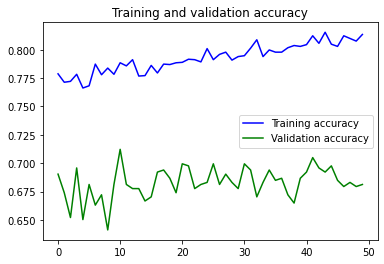

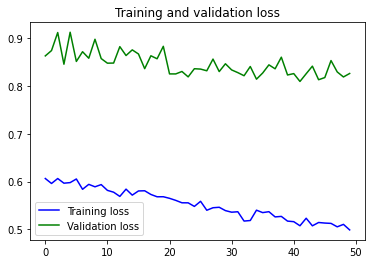

In [77]:
#model = load_model('name_of_model_to_load.h5')
epoch_num=PARAMS['n_epochs']
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(range(epoch_num), acc, 'b', label='Training accuracy')
plt.plot(range(epoch_num), val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()


loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(range(epoch_num), loss, 'b', label='Training loss')
plt.plot(range(epoch_num), val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


plt.show()

### Test model on *'test'* dataset

In [78]:
test_score = model.evaluate(test)
print(model.metrics_names)
print(test_score)
print()
print("Accuracy = ",test_score[1]*100,'%')

18/18 [==============================] - 2s 87ms/step - loss: 0.8648 - acc: 0.6800
['loss', 'acc']
[0.8648242950439453, 0.6800000071525574]

Accuracy =  68.00000071525574 %


## Augmentation

## Transfer learning

In [79]:
tensorflow.keras.backend.clear_session()

In [80]:
from tensorflow.keras.applications import VGG16

In [81]:
pretrained_net = VGG16(input_shape=(100,100,3),include_top=False,weights='imagenet')

In [82]:
pretrained_net.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [83]:
for layer in pretrained_net.layers:
    layer.trainable=False

In [84]:
model = models.Sequential()
model.add(pretrained_net)
model.add(layers.Flatten())
model.add(layers.Dense(5, activation='softmax'))

In [85]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 23045     
Total params: 14,737,733
Trainable params: 23,045
Non-trainable params: 14,714,688
_________________________________________________________________


In [86]:
# compile model (and choose optimiser )
model.compile(loss=PARAMS['loss'],
              optimizer=optimizers.RMSprop(PARAMS['lr']),
              metrics=[PARAMS['metrics']])

In [87]:
# Fit the model 
spe=len(train)   # train_size/batch_size
epoch_num=PARAMS['n_epochs']
val_steps=len(validation)  # validation_size/batch_size


history = model.fit(
            train,
            steps_per_epoch=spe,  
            epochs=epoch_num,
            validation_data=validation,
            validation_steps=val_steps) 
#model.save(PARAMS['save_model'])

Epoch 1/50
81/81 [==============================] - 48s 585ms/step - loss: 1.6576 - acc: 0.2314 - val_loss: 1.4914 - val_acc: 0.3789
Epoch 2/50
81/81 [==============================] - 47s 580ms/step - loss: 1.4602 - acc: 0.3902 - val_loss: 1.3676 - val_acc: 0.4900
Epoch 3/50
81/81 [==============================] - 47s 579ms/step - loss: 1.3354 - acc: 0.5090 - val_loss: 1.2734 - val_acc: 0.5647
Epoch 4/50
81/81 [==============================] - 47s 579ms/step - loss: 1.2460 - acc: 0.5619 - val_loss: 1.2026 - val_acc: 0.6102
Epoch 5/50
81/81 [==============================] - 47s 577ms/step - loss: 1.1680 - acc: 0.6130 - val_loss: 1.1434 - val_acc: 0.6157
Epoch 6/50
81/81 [==============================] - 47s 579ms/step - loss: 1.1207 - acc: 0.6030 - val_loss: 1.0950 - val_acc: 0.6430
Epoch 7/50
81/81 [==============================] - 47s 579ms/step - loss: 1.0533 - acc: 0.6545 - val_loss: 1.0584 - val_acc: 0.6503
Epoch 8/50
81/81 [==============================] - 47s 580ms/step - 

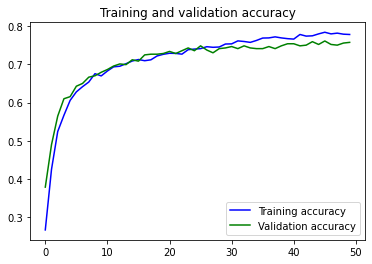

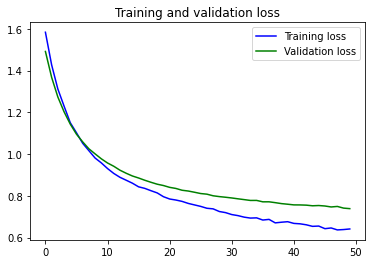

In [90]:
#model = load_model('name_of_model_to_load.h5')
epoch_num=PARAMS['n_epochs']
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(range(epoch_num), acc, 'b', label='Training accuracy')
plt.plot(range(epoch_num), val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()


loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(range(epoch_num), loss, 'b', label='Training loss')
plt.plot(range(epoch_num), val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


plt.show()

In [91]:
test_score = model.evaluate(test)
print(model.metrics_names)
print(test_score)
print()
print("Accuracy = ",test_score[1]*100,'%')

18/18 [==============================] - 8s 457ms/step - loss: 0.7085 - acc: 0.7527
['loss', 'acc']
[0.7084954977035522, 0.7527272701263428]

Accuracy =  75.27272701263428 %


In [184]:
labels=(train.class_indices)

In [187]:
print(labels)

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}


In [193]:
labels=dict((value,key) for key, value in labels.items())

In [197]:
predicted_class=labels[np.argmax([0,0.87,0.1,0.03,0],axis=-1)]

In [198]:
print(predicted_class)

dandelion
